In [1]:
import pyspark
import os.path

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from getpass import getpass
import pandas as pd
import pickle

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
conf = pyspark.SparkConf().setAll([('spark.app.name', 'Spark Data Exploration')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

print (spark.version)
print (pyspark.version)

conf.getAll()

2.4.0
<module 'pyspark.version' from '/anaconda3/lib/python3.6/site-packages/pyspark/version.py'>


dict_items([('spark.app.name', 'Spark Data Exploration')])

In [3]:
fpathA = 'ecommerce/order_items_dataset.csv'
fpathB = 'ecommerce/customers_dataset.csv'
fpathC = 'ecommerce/geolocation_dataset.csv'
fpathD = 'ecommerce/order_payments_dataset.csv'
fpathE = 'ecommerce/orders_dataset.csv'
fpathF = 'ecommerce/products_dataset.csv'
fpathG = 'ecommerce/sellers_dataset.csv'
fpathH = 'ecommerce/product_category_name_translation.csv'
fpathI = 'ecommerce/customer_reviews_dataset.csv'

orders = pd.read_csv(fpathE)
orderItems = pd.read_csv(fpathA)
customerReviews = pd.read_csv(fpathI)
products = pd.read_csv(fpathF)

In [4]:
from datetime import  datetime
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
orders['order_customer_delivery_date'] = pd.to_datetime(orders['order_customer_delivery_date'])
duration = (orders.order_customer_delivery_date - orders.order_estimated_delivery_date).astype(int)
duration = pd.Series.to_frame(duration)
orders['duration'] = duration

In [5]:
mergedOrdersDF = orders[['order_id', 'order_status', 'duration']]
orderItemsDF = orderItems[['order_id', 'product_id', 'price', 'freight_value']]
customerReviewsDF = customerReviews[['order_id', 'survey_score']]
productDF = products[['product_id', 'product_category_name']]

In [6]:
tempDF = orderItemsDF.merge(productDF, on=['product_id'], how='outer')
tempDF2 =  mergedOrdersDF.merge(tempDF, on=['order_id'], how='outer')
mergedDF = customerReviewsDF.merge(tempDF2, on=['order_id'], how='outer')

In [7]:
mergedDF.count()

order_id                 114100
survey_score             114100
order_status             114100
duration                 114100
product_id               113322
price                    113322
freight_value            113322
product_category_name    111710
dtype: int64

In [8]:
mergedDF = mergedDF.dropna(how='any')
mergedDF = mergedDF[['survey_score', 'order_status', 'duration', 'product_id', 'price', 'freight_value', 'product_category_name']]
mergedDF.count()

survey_score             111710
order_status             111710
duration                 111710
product_id               111710
price                    111710
freight_value            111710
product_category_name    111710
dtype: int64

In [33]:
from keras import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras_pandas.Automater import Automater
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [10]:
# Train /test split
train_observations, test_observations = train_test_split(mergedDF, test_size=0.001, random_state=42)
train_observations = train_observations.copy()
test_observations = test_observations.copy()
train_observations.head()

,survey_score,order_status,duration,product_id,price,freight_value,product_category_name
17973,5,delivered,-332859000000000,c6a988c762b18da642d772a1f1ddb782,25.00,21.15,utilidades_domesticas
36157,4,delivered,-463645000000000,2481a472d98c582b46bc2dfeae6f539f,59.55,13.44,moveis_decoracao
85937,5,delivered,-1545233000000000,f32af0a8b0bcb05b60f05e8907ad8866,29.90,14.52,moveis_decoracao
65627,5,delivered,-1317205000000000,99a4788cb24856965c36a24e339b6058,79.90,23.36,cama_mesa_banho
108543,5,delivered,-1134083000000000,368c6c730842d78016ad823897a372db,49.90,13.37,ferramentas_jardim


In [109]:
# Transform the data set, using keras_pandas
categorical_vars = ['order_status', 'product_category_name']
numerical_vars = ['duration', 'price', 'freight_value', 'survey_score']
text_vars = ['product_id']

data_type_dict = {'numerical': numerical_vars, 'categorical': categorical_vars, 'text': text_vars}
output_var = 'survey_score'
auto = Automater(data_type_dict=data_type_dict, output_var=output_var)
auto.fit(train_observations)

# Transform data
# scaler = StandardScaler()
train_X, train_y = auto.fit_transform(train_observations)
test_X, test_y = auto.transform(test_observations)
# train_X = scaler.fit_transform(train_X)
# temp = np.asarray(train_X)
# train_X, train_y = makeOverSamplesSMOTE(tempX.T, train_y)

# Create and fit keras (deep learning) model.
x = auto.input_nub

# Fill in your own hidden layers
# x = Dense(14, kernel_initializer='normal')(x)
# x = Dropout(rate= 0.1)(x)
x = Dense(12, activation = 'relu', kernel_initializer = 'uniform')(x)
x = Dropout(rate= 0.2)(x)
x = Dense(6, activation='relu', kernel_initializer = 'uniform')(x)
x = Dropout(rate= 0.2)(x)
x = Dense(1, activation='linear', kernel_initializer = 'uniform')(x)

x = auto.output_nub(x)

model = Model(inputs=auto.input_layers, outputs=x)
model.compile(loss=auto.suggest_loss(), optimizer='adam', metrics=['mse','mae'])
history = model.fit(train_X, train_y, epochs=10, batch_size=150, validation_split=.1)

Train on 100438 samples, validate on 11160 samples
Epoch 1/10
100438/100438 [==============================] - 48s 481us/step - loss: 0.9554 - mean_squared_error: 0.9554 - mean_absolute_error: 0.7730 - val_loss: 0.9294 - val_mean_squared_error: 0.9294 - val_mean_absolute_error: 0.7686
Epoch 2/10
100438/100438 [==============================] - 41s 412us/step - loss: 0.9317 - mean_squared_error: 0.9317 - mean_absolute_error: 0.7635 - val_loss: 0.9279 - val_mean_squared_error: 0.9279 - val_mean_absolute_error: 0.7552
Epoch 3/10
100438/100438 [==============================] - 41s 412us/step - loss: 0.9142 - mean_squared_error: 0.9142 - mean_absolute_error: 0.7548 - val_loss: 0.9281 - val_mean_squared_error: 0.9281 - val_mean_absolute_error: 0.7629
Epoch 4/10
100438/100438 [==============================] - 42s 416us/step - loss: 0.9005 - mean_squared_error: 0.9005 - mean_absolute_error: 0.7471 - val_loss: 0.9250 - val_mean_squared_error: 0.9250 - val_mean_absolute_error: 0.7611
Epoch 5/1

dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'mean_squared_error', 'mean_absolute_error'])


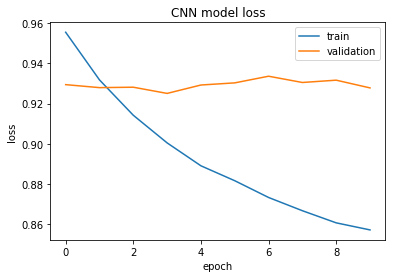

In [110]:
print(history.history.keys())
# "Loss"
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [99]:
# make a prediction
preds = model.predict(test_X)
# print(len(test_X[0]))
# print(len(test_Y))
# show the inputs and predicted outputs
predict = []
for i in range(len(test_X[0])):
    predict.append((preds[i]))

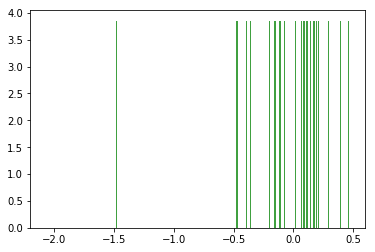

In [100]:
n, bins, patches = plt.hist(predict, density=True, facecolor='g', alpha=0.75)
plt.show()